In [1]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import pysal as ps

sns.set(style="whitegrid")

In [2]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'

In [3]:
# Read data and drop dead columns
broker = pd.read_csv(broker_data)
broker.head()
broker = broker.drop(['Leg #', 'Brokered Margin %','Carrier Pay','Booking Agent','Booking Agent ID','Brokered Revenue','Destination State','Destination City','Cust ID','Carrier ID','Origin City'], axis = 1)
broker

,Order #,Start Date,Agent Office,Customer,Carrier,OriginState,Brokered Margin
0,1361713,8/15/2018,1,AMNP,43708,Texas,$100.00
1,1501026,1/30/2018,1,AMNP,442007,Indiana,$100.00
2,1518714,1/5/2018,1,AMNP,971955,Colorado,$-
3,1538821,4/2/2018,1,AMNP,355478,Texas,$100.00
4,1601007,8/22/2018,1,AMNP,184749,North Dakota,$100.00
...,...,...,...,...,...,...,...
213739,2341809,5/28/2021,10,MONEAS,TX6877A,Texas,$200.00
213740,2347760,5/28/2021,16,CHICHA,770152,Delaware,$143.96
213741,2347761,5/31/2021,16,CHICHA,770152,Delaware,$143.96
213742,2347762,5/31/2021,16,CHICHA,770152,Delaware,$143.96


In [4]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [5]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [6]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [7]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [8]:
#filter out data prior to start date to have rolling 12 months; rename origin column to state
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {'OriginState':'NAME'}, inplace = True)


#Check data types to make sure margin can be integers
for col in filteredBroker.columns:
    print(col)

filteredBroker

print(filteredBroker.dtypes)

Order #
Start Date
Agent Office
Customer
Carrier
NAME
Brokered Margin
Order #                     int64
Start Date         datetime64[ns]
Agent Office                int64
Customer                   object
Carrier                    object
NAME                       object
Brokered Margin            object
dtype: object


C:\Users\steph\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
# Filter out contracted offices
agents = [1, 7, 8, 10, 18, 20, 21, 22, 23, 24, 27, 29,30,5,6,17]

#Track out sister company offices
#sister_agents = [5, 6, 17]

inverse_boolean_series = ~filteredBroker['Agent Office'].isin(agents)
filteredBroker = filteredBroker[inverse_boolean_series]
filteredBroker

,Order #,Start Date,Agent Office,Customer,Carrier,NAME,Brokered Margin
145956,2079035,2020-06-22,14,NPPDU,CTLO,Indiana,$7.55
148015,2084391,2020-05-31,12,WWBO,870923,Colorado,$351.22
148521,2085776,2020-06-02,14,ALNA,766974,Wisconsin,$165.00
148580,2085886,2020-06-05,14,CONELP,179534,Wisconsin,$223.19
148605,2085949,2020-06-08,14,CONELP,157540,Wisconsin,$77.28
...,...,...,...,...,...,...,...
213738,2341420,2021-05-27,16,CHICHA,770152,Delaware,$143.96
213740,2347760,2021-05-28,16,CHICHA,770152,Delaware,$143.96
213741,2347761,2021-05-31,16,CHICHA,770152,Delaware,$143.96
213742,2347762,2021-05-31,16,CHICHA,770152,Delaware,$143.96


In [10]:
# Numeric variables maintained
varis = ['Brokered Margin']
varis_2 = ['Order #']

In [11]:
#Group data by state
states = filteredBroker.groupby('NAME')[varis].count()
load_count = filteredBroker.groupby('NAME')[varis_2].count()

# Combine data sets
states = pd.merge(states, load_count, on=["NAME"])

states

,Brokered Margin,Order #
NAME,,
Alabama,60,60
Arizona,102,102
Arkansas,238,238
California,1309,1309
Colorado,868,868
Connecticut,382,382
Delaware,12337,12337
Florida,50,50
Georgia,298,298


In [12]:
statesct = filteredBroker.groupby(['NAME']).describe().loc[:,(slice(None),['count'])]
#statesct

In [13]:
#Find max smallest region volume (eg state) for limits
max_state_volume = states['Order #'].max()
max_state_volume
total_loads = filteredBroker[varis_2].count()
max_state_share = max_state_volume / total_loads
max_state_share

Order #    0.329769
dtype: float64

In [14]:
#Max Load Volume in a region
volume_limit = 0.4
max_load = total_loads*volume_limit
max_load

Order #    14964.4
dtype: float64

In [15]:
#Code placeholder to set threshold and add as variable
#n_rev = lst.groupby('zipcode')\
#           .sum()\
#           ['number_of_reviews']\
#           .rename(lambda x: str(int(x)))\
 #          .reindex(zrt['zipcode'])
#thr = np.round(0.1 * n_rev.sum())
#thr

In [16]:
#Group by customers and carriers and convert to binary
types = pd.get_dummies(filteredBroker['Customer'])
region_types = types.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
types_2 = pd.get_dummies(filteredBroker['Carrier'])
region_types = types_2.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
region_types_pct.info()
region_types_pct

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Alabama to Wisconsin
Columns: 7717 entries, 008484A to ZTLMI
dtypes: float64(7717)
memory usage: 2.8+ MB


,008484A,011099A,032654A,042077A,056299A,058054A,068781A,072462A,1000145,1000319,...,WTIMO,WTIWA,YTSDA,YTTEL,ZBTPA,ZSOM,ZTHA,ZTHO,ZTKI,ZTLMI
NAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arizona,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arkansas,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
California,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Colorado,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.115207,0.000000,0.000000,0.000000,0.000000,0.000000
Connecticut,0.000000,0.26178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delaware,0.000000,0.00000,0.008106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.258815,0.000000,0.000000
Florida,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Georgia,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
# Combine data sets
region_props = pd.merge(states, region_types, on=["NAME"])

In [18]:
#Scale not applicable because only 1 numeric variable
#db = pd.DataFrame(\
 #                scale(region_props), \
  #               index=region_props.index, \
   #              columns=region_props.columns)\
    #   .rename(lambda x: str(int(x)))
db = region_props

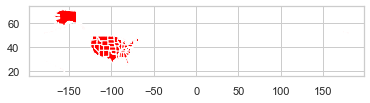

In [19]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [20]:
# match geojson dataframe and broker_data on 'state'
statedb = usMap[['geometry', 'STATE', 'NAME']].join(db, on='NAME')\
                                         .dropna()

In [21]:
#Optimal Cluster Calculations
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    #km.fit(X)
    km = km.fit(statesct) #count of Origin state
    Sum_of_squared_distances.append(km.inertia_)

C:\Users\steph\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
Sum_of_squared_distances

[338805163.9148937,
 66381811.86956524,
 17334802.344322342,
 7426201.153846154,
 3363944.4285714286,
 1726240.0194805192,
 994924.0666666664,
 557524.0666666667,
 309676.70714285714]

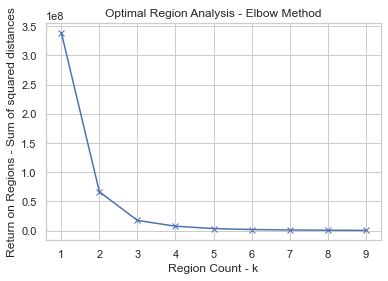

In [23]:
#optimal clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Region Count - k')
plt.ylabel('Return on Regions - Sum of squared distances')
plt.title('Optimal Region Analysis - Elbow Method')
plt.savefig('Elbow Method')

In [24]:
#Cluster in specfic groups
cluster_count = 5
km5 = cluster.KMeans(n_clusters=cluster_count)

In [25]:
# Fit to data
km5cls = km5.fit(statedb.drop(['geometry', 'NAME'], axis=1).values)

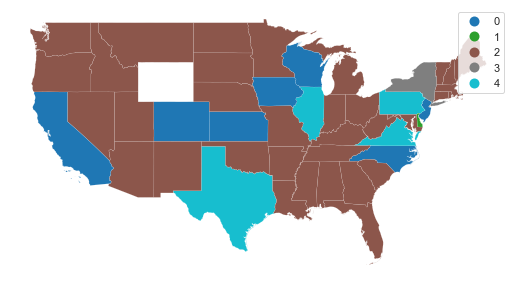

In [26]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

statedb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()
statedb['km5cls'] = km5cls.labels_
plt.savefig('Regions')

In [27]:
# Region sizes
k5sizes = statedb.groupby('km5cls').size()
k5sizes


km5cls
0     7
1     1
2    34
3     1
4     4
dtype: int64

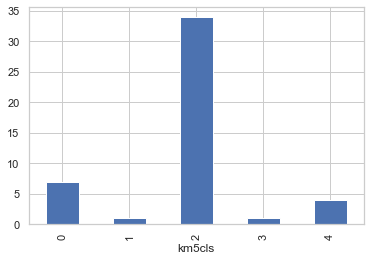

In [28]:
#Visualize attributes and mix
_ = k5sizes.plot.bar()

In [29]:
k5sizes_df = statedb.groupby('km5cls').size().to_frame(name = 'State Count')
k5sizes_df

,State Count
km5cls,
0,7
1,1
2,34
3,1
4,4


In [30]:
statedb

,geometry,STATE,NAME,Brokered Margin,Order #,008484A,011099A,032654A,042077A,056299A,...,WTIWA,YTSDA,YTTEL,ZBTPA,ZSOM,ZTHA,ZTHO,ZTKI,ZTLMI,km5cls
0,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...",23,Maine,22.0,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...",25,Massachusetts,75.0,75.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...",26,Michigan,252.0,252.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,"POLYGON ((-104.05770 44.99743, -104.25015 44.9...",30,Montana,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,"POLYGON ((-114.05060 37.00040, -114.04999 36.9...",32,Nevada,30.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5,"POLYGON ((-75.52684 39.65571, -75.52634 39.656...",34,New Jersey,905.0,905.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,"MULTIPOLYGON (((-71.94356 41.28668, -71.92680 ...",36,New York,4324.0,4324.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3
7,"MULTIPOLYGON (((-82.60288 36.03983, -82.60074 ...",37,North Carolina,701.0,701.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
8,"MULTIPOLYGON (((-82.81349 41.72347, -82.81049 ...",39,Ohio,464.0,464.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
9,"POLYGON ((-75.41504 39.80179, -75.42804 39.809...",42,Pennsylvania,2593.0,2593.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,282.0,0.0,0.0,4


In [31]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
Avg_Margin = statedb.groupby('km5cls')['Brokered Margin'].mean().to_frame(name = 'Mean Margin').reset_index()
# Transpose the table and print it rounding each value
# to three decimals
Avg_Margin = Avg_Margin.round(3)

Avg_Margin

,km5cls,Mean Margin
0,0,948.571
1,1,12337.000
2,2,150.500
3,3,4324.000
4,4,2188.000


In [32]:
Load_Volume = statedb.groupby('km5cls')['Order #'].sum().to_frame(name = 'Annual Load Volume').reset_index()
Load_Volume

,km5cls,Annual Load Volume
0,0,6640.0
1,1,12337.0
2,2,5117.0
3,3,4324.0
4,4,8752.0


In [33]:
#Merge tables
region_desc = pd.merge(k5sizes_df, Avg_Margin, how='left', on='km5cls')
regiondesc = pd.merge(region_desc, Load_Volume, how='left', on='km5cls').rename(columns = {'km5cls':'Region'}, inplace = False)
regiondesc

,Region,State Count,Mean Margin,Annual Load Volume
0,0,7,948.571,6640.0
1,1,1,12337.000,12337.0
2,2,34,150.500,5117.0
3,3,1,4324.000,4324.0
4,4,4,2188.000,8752.0


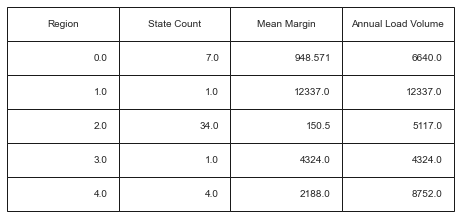

In [34]:
def render_mpl_table(data, col_width=3, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(True)
    mpl_table.set_fontsize(font_size)

render_mpl_table(regiondesc, header_columns=0, col_width=2.0)
plt.savefig('Region Propertieslrg')

In [37]:
from PIL import Image
image = Image.open('Region Propertieslrg.png')
image = image.resize((300,300),Image.ANTIALIAS)
image.save(fp='Region Properties.png')